# CartPole by virtual display
https://medium.com/@kaleajit27/reinforcement-learning-on-google-colab-9cb2e1ef51e

In [1]:
# activate virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

# CartPole
https://www.kumilog.net/entry/openai-gym-rl

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode finished after 14 timesteps


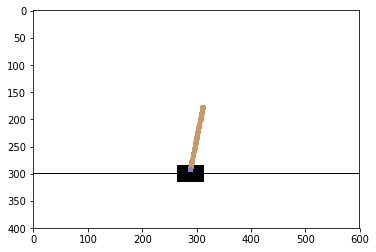

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

# 環境の作成
env = gym.make('CartPole-v0')

# 環境の初期化
env.reset()

# 1000step回す
for t in range(1000):
#    env.render()  # 描画
    plt.imshow(env.render('rgb_array'))

    action = env.action_space.sample()  # ランダムに行動を選択
    observation, reward, done, info = env.step(action)  # 行動を実行
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break

In [13]:
import argparse
from collections import defaultdict

import gym
import numpy as np


class Q(object):

    def __init__(self, action_space, observation_space, bin_size):
        self.n_actions = action_space.n
        self.observation_space = observation_space
        self.config = {
            'low_bound': None,
            'high_bound': None,
            'init_mean': 0.0,
            'init_std': 0.0
        }
        self._observation_dimension = 1
        for d in self.observation_space.shape:
            self._observation_dimension *= d

        if isinstance(bin_size, list):
            self._bin_sizes = bin_size
        else:
            self._bin_sizes = [bin_size] * self._observation_dimension

        self._dimension_bins = []
        for i, low, high in self._low_high_iter():
            b_size = self._bin_sizes[i]
            bins = self._make_bins(low, high, b_size)
            self._dimension_bins.append(bins)

            mean = self.config['init_mean']
            std = self.config['init_std']
        self.table = defaultdict(lambda: std * np.random.randn(self.n_actions) + mean)

    def _make_bins(self, low, high, bin_size):
        bins = np.arange(low, high, (float(high) - float(low)) / (bin_size - 2))
        if min(bins) < 0 and 0 not in bins:
            bins = np.sort(np.append(bins, [0]))
        return bins

    def _low_high_iter(self):
        lows = self.observation_space.low
        highs = self.observation_space.high
        low_bound = self.config['low_bound']
        high_bound = self.config['high_bound']

        for i in range(len(lows)):
            low = lows[i]
            if low_bound is not None:
                _low_bound = low_bound if not isinstance(low_bound, list) else low_bound[i]
                low = low if _low_bound is None else max(low, _low_bound)

            high = highs[i]
            if high_bound is not None:
                _high_bound = high_bound if not isinstance(high_bound, list) else high_bound[i]
                high = high if _high_bound is None else min(high, _high_bound)

            yield i, low, high

    def observation_to_state(self, observation):
        state = 0
        unit = max(self._bin_sizes)
        for d, o in enumerate(observation.flatten()):
            state = state + np.digitize(o, self._dimension_bins[d]) * pow(unit, d)
        return state

    def values(self, observation):
        state = self.observation_to_state(observation)
        return self.table[state]


class QAgent(object):
    def __init__(self, q):
        self.config = {
            'learning_rate': 0.1,
            'init_eps': 0.5,
            'gamma': 0.95,
            'n_iter': 200}
        self.q = q
        self.eps = self.config['init_eps']

    def act(self, obs):
        if self.eps > 0.1:
            self.eps *= 0.9999
        else:
            self.eps = 0.1

        if np.random.random() < self.eps:
            action = np.random.choice(self.q.n_actions)
        else:
            action = np.argmax(self.q.values(obs))

        return action

    def train(self, obs, next_obs, reward, done):
        lr = self.config['learning_rate']
        gamma = self.config['gamma']

        action = self.act(obs)
        state = self.q.observation_to_state(obs)

        future = 0.0
        if not done:
            future = np.max(self.q.values(next_obs))

        loss = reward + gamma * future - self.q.table[state][action]
        self.q.table[state][action] += lr * loss

        return loss


def main(args):
    print('Make {} environment'.format(args.env_id))
    env = gym.make(args.env_id)

    env = gym.wrappers.Monitor(env, directory=args.out, force=True)
    env.seed(0)
    q = Q(env.action_space, env.observation_space, bin_size=[3, 3, 8, 5])
    agent = QAgent(q)

    for e in range(args.episode):
        obs = env.reset()
        R = 0
        L = 0
        reward = 0
        action = env.action_space.sample()
        done = False
        for t in range(agent.config['n_iter']):
            env.render()

            if args.random:
                action = env.action_space.sample()
            else:
                action = agent.act(obs)
            next_obs, reward, done, _ = env.step(action)
            if done:
                reward = -200
            loss = agent.train(obs, next_obs, reward, done)

            if args.verbose:
                print('iter: {}'.format(t))
                print('\tobservation: {}'.format(obs))
                print('\taction: {}'.format(action))
                print('\treward: {}'.format(reward))
                print('\tloss: {}'.format(loss))
                print('\teps: {}'.format(agent.eps))

            if done:
                break

            obs = next_obs
            R += reward
            L += loss
        print('Episode {}: total reward={}, average loss={:.4f}'.format(e, R, L/t))

    env.close()


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument('env_id', nargs='?', default='CartPole-v0',
                        help='Select the environment to run')
    parser.add_argument('--episode', '-e', type=int, default=100,
                        help='Number of episodes')
    parser.add_argument('--out', '-o', default='result',
                        help='Directory to output the result')
    parser.add_argument('--random', '-r', action='store_true')
    parser.add_argument('--verbose', '-v', action='store_true')
    main(parser.parse_args())

usage: ipykernel_launcher.py [-h] [--episode EPISODE] [--out OUT] [--random]
                             [--verbose]
                             [env_id]
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
# 環境の作成
env = gym.make('CartPole-v0')

frames = []
for i in range(3):
    obs = env.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.act(obs)
#        action=2
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
    agent.stop_episode()
env.render()

import matplotlib.animation
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


NameError: name 'agent' is not defined